# Note:  
V1 
- Create flow of modelling with Logistic Regression.

In [1]:
import pandas as pd
pd.set_option('display.max_columns', 100)
import numpy as np
import random
import seaborn as sns
import matplotlib.pyplot as plt

seed_no = 572

import warnings
warnings.filterwarnings("ignore")

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression


# Load data

In [3]:
df_trn = pd.read_csv('data/x_train_82.csv', index_col='index')
df_tst = pd.read_csv('data/x_test_82.csv', index_col='index')

In [4]:
print(df_trn.shape, df_tst.shape)
df_trn.head()

(847, 8) (212, 8)


,pH,Temprature,Taste,Odor,Fat,Turbidity,Colour,Grade
index,,,,,,,,
244,6.5,38,1,0,1,0,255,medium
824,6.8,45,0,0,0,1,255,medium
602,5.6,50,0,1,1,1,255,low
347,8.6,55,0,1,1,1,255,low
753,6.6,38,0,0,0,0,255,medium


# Preprocessing function

In [5]:
def encode_label(df_in):
    df_fnc = df_in.copy()
    df_fnc.loc[df_fnc['Grade']=='low', 'Grade'] = 0
    df_fnc.loc[df_fnc['Grade']=='medium', 'Grade'] = 1
    df_fnc.loc[df_fnc['Grade']=='high', 'Grade'] = 2
    df_fnc['Grade'] = df_fnc['Grade'].astype(int)
    
    return df_fnc

df_trn = encode_label(df_trn)
df_tst = encode_label(df_tst)

In [6]:
df_trn.head(2)

,pH,Temprature,Taste,Odor,Fat,Turbidity,Colour,Grade
index,,,,,,,,
244,6.5,38,1,0,1,0,255,1
824,6.8,45,0,0,0,1,255,1


In [7]:
# Prepare for training
y_trn = df_trn[['Grade']]
X_trn = df_trn.drop(columns='Grade')

y_tst = df_tst[['Grade']]
X_tst = df_tst.drop(columns='Grade')

print(y_trn.shape, X_trn.shape)
print(y_tst.shape, X_tst.shape)

(847, 1) (847, 7)
(212, 1) (212, 7)


In [8]:
# Scaler
scaler = StandardScaler()
X_trn_scale = pd.DataFrame(scaler.fit_transform(X_trn))
X_trn_scale.columns = X_trn.columns
X_trn_scale.index = X_trn.index

X_tst_scale = pd.DataFrame(scaler.transform(X_tst))
X_tst_scale.columns = X_tst.columns
X_tst_scale.index = X_tst.index

In [9]:
X_trn_scale.head(2)

,pH,Temprature,Taste,Odor,Fat,Turbidity,Colour
index,,,,,,,
244,-0.091649,-0.607768,0.902056,-0.882843,0.691509,-0.989430,0.744513
824,0.122987,0.067163,-1.108579,-0.882843,-1.446112,1.010683,0.744513


# Train model

## CV - Hyperparameters tuning

In [10]:
# Create a stratified 5-fold cross-validator
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed_no)

In [28]:
# Create a Logistic Regression classifier
logreg_classifier = LogisticRegression(random_state=seed_no)

# Define the hyperparameter grid to search for Logistic Regression
param_grid_logreg = {
    'penalty': ['l1', 'l2', 'elasticnet', None],
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'saga'],
    'max_iter': [50, 100, 150, 200, 500]
}

# Use GridSearchCV to search for the best hyperparameters
grid_search_logreg = GridSearchCV(estimator=logreg_classifier,
                                   param_grid=param_grid_logreg,
                                   cv=skf,
                                   scoring='f1_macro',
                                   verbose=1)
grid_search_logreg.fit(X_trn_scale, y_trn)

# Get the best hyperparameters
best_params_logreg = grid_search_logreg.best_params_
print("Best Hyperparameters (Logistic Regression):", best_params_logreg)
print("Best Score (Logistic Regression):", grid_search_logreg.best_score_)

# Use the best model to make predictions on the test set
model_best_params = grid_search_logreg.best_estimator_


Fitting 5 folds for each of 240 candidates, totalling 1200 fits
Best Hyperparameters (Logistic Regression): {'C': 10, 'max_iter': 50, 'penalty': 'l1', 'solver': 'liblinear'}
Best Score (Logistic Regression): 0.8519325420195587


## Retrain the whole training data with the best parameters

In [29]:
# GridSearchCV return the retrained model with whole dataset
y_trn_pred = model_best_params.predict(X_trn_scale)

## Evaluate the model/log score
print(classification_report(y_trn, y_trn_pred))

              precision    recall  f1-score   support

           0       0.88      0.88      0.88       343
           1       0.94      0.85      0.89       299
           2       0.73      0.83      0.78       205

    accuracy                           0.86       847
   macro avg       0.85      0.85      0.85       847
weighted avg       0.86      0.86      0.86       847



## Feature Importance

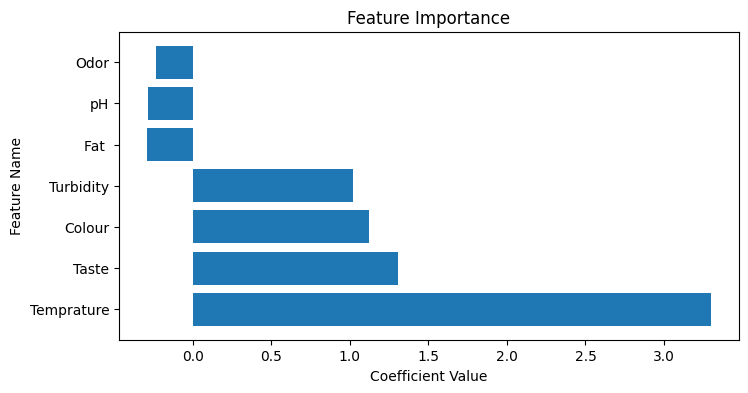

In [30]:
# Access the coefficients
coefficients = model_best_params.coef_[0]

# Get the corresponding feature names
feature_names = X_trn.columns  # Replace this with the actual feature names used in your model

# Create a dictionary to store feature names and their coefficients
feature_importance = dict(zip(feature_names, coefficients))

# Sort features by their absolute coefficients for better visualization
sorted_features = sorted(feature_importance.items(), key=lambda x: abs(x[1]), reverse=True)

# Extract sorted feature names and coefficients
sorted_feature_names, sorted_coefficients = zip(*sorted_features)

# Plotting
plt.figure(figsize=(8, 4))
plt.barh(range(len(sorted_feature_names)), sorted_coefficients, align='center')
plt.yticks(range(len(sorted_feature_names)), sorted_feature_names)
plt.xlabel('Coefficient Value')
plt.ylabel('Feature Name')
plt.title('Feature Importance')
plt.show()

## Performance on Test data

In [31]:
# Make predictions on the test set
y_test_pred = model_best_params.predict(X_tst_scale)

# Evaluate the model
accuracy = accuracy_score(y_tst, y_test_pred)
print(f"Accuracy: {accuracy}")

# Display classification report
print("Classification Report:")
print(classification_report(y_tst, y_test_pred))

Accuracy: 0.8443396226415094
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.85      0.86        86
           1       0.95      0.81      0.88        75
           2       0.69      0.88      0.78        51

    accuracy                           0.84       212
   macro avg       0.84      0.85      0.84       212
weighted avg       0.86      0.84      0.85       212



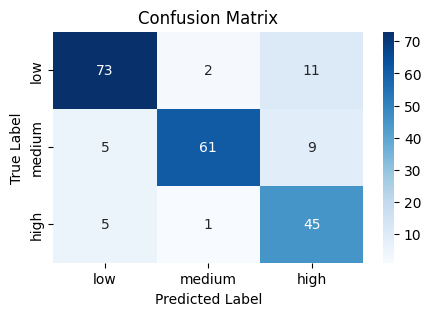

In [32]:
# Get the confusion matrix
conf_matrix = confusion_matrix(y_tst, y_test_pred)

# Display the confusion matrix using a heatmap
class_names = ['low', 'medium', 'high']
plt.figure(figsize=(5, 3))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# EDA Error (Testing dataset)

In [33]:
# Merge prediction with the testing dataset
df_test_perf = y_tst.copy()
df_test_perf['pred_test'] = y_test_pred
df_test_perf = X_tst.merge(df_test_perf, left_index=True, right_index=True)

# Explore Error
df_error = df_test_perf[df_test_perf['Grade']!=df_test_perf['pred_test']]
print(f"Number of False Prediction: {df_error.shape[0]} ({(100*df_error.shape[0]/y_tst.shape[0]):.02f}%)")
df_test_perf[df_test_perf['Grade']!=df_test_perf['pred_test']]

Number of False Prediction: 33 (15.57%)


,pH,Temprature,Taste,Odor,Fat,Turbidity,Colour,Grade,pred_test
index,,,,,,,,,
804,4.5,38,0,1,1,1,255,0,2
338,6.7,45,1,1,1,0,245,1,2
92,6.6,50,0,0,0,0,255,0,1
586,9.0,43,1,1,1,1,248,0,2
471,6.5,38,1,0,1,0,255,1,2
197,6.8,45,0,0,0,1,255,1,0
88,9.0,43,1,1,1,1,248,0,2
527,6.5,38,1,0,1,0,255,1,2
948,6.8,45,1,1,1,1,245,2,0
